https://github.com/microsoft/textworld

- Playing a game (terminal)
- tw-play gen_games/tw-game-vjs3cos0-house-GP-OgOJFl9Jtba5I1Rb.ulx

In [1]:
import random
import numpy as np
import textworld
import matplotlib.pyplot as plt
#import nltk
#from nltk.tokenize import word_tokenize
#from nltk.chunk import ne_chunk
#from nltk.tag import pos_tag
#from nltk.tree import Tree

In [2]:
def get_room(desc):
    
    room = ''
    lines = desc
    lines = lines.lower()
    lines = lines.split('\n')
    line = lines[0]
    line = line.strip()
    if "-=" in line and "=-" in line:
        room = line.split(" ")[1]
    
    return room    


def get_command(command_list):    
    if len(command_list) > 0:
        r = random.randint(0,len(command_list)-1)
        c = command_list[r]
        return c
    
    return ''


def get_command_with_memory(command_list):
    global my_memory,step_total,step_count

    learn_rate = round((step_count / step_total)*100)
    r = random.randint(0,100)
    
    if r < learn_rate:
        command_in_memory = []

        for c in command_list:
            for m in my_memory:
                if c == m[1] and m[3] > 0:
                    command_in_memory.append(c)

        if len(command_in_memory)>0:
            r = random.randint(0,len(command_in_memory)-1)
            c = command_in_memory[r]
            return c
        else:
            return get_command(command_list)
    else:
        return get_command(command_list)



def get_good_command(command_list):
    
    good_command = []
    for c in command_list:
        if 'insert' in c or 'take' in c or 'go' in c:
        #if 'insert' in c or 'take' in c or 'go' in c or 'open' in c:
        #if 'drop' not in c and 'examine' not in c and 'close' not in c:
        #if 'examine' not in c:
            good_command.append(c)
    
    if len(good_command) > 0:
        r = random.randint(0,len(good_command)-1)
        c = good_command[r]
        return c
    
    r = random.randint(0,len(command_list)-1)
    c = command_list[r]
    return c


def get_good_command_with_memory(command_list):
    global my_memory,step_total,step_count

    #sort
    #my_memory.sort(key=lambda x: x[3])

    learn_rate = round((step_count / step_total)*100)
    #print(learn_rate)
    r = random.randint(0,100)
    
    if r < learn_rate:
        good_command_in_memory = []

        for c in command_list:
            for m in my_memory:
                if c == m[1] and m[3] > 0:
                    good_command_in_memory.append(c)

        if len(good_command_in_memory)>0:
            r = random.randint(0,len(good_command_in_memory)-1)
            c = good_command_in_memory[r]
            return c
        else:
            return get_good_command(command_list)
    else:
        return get_good_command(command_list)


def update_memory(state,command,next_state,reward):
    global my_memory
    
    has_update = False
    for r in my_memory:
        if r[0] == state and r[1] == command and r[2] == next_state:
            r[3] += reward
            has_update = True
            break
    
    if has_update == False:
        my_memory.append([state,command,next_state,reward])
        
    #print('memory_record number:',len(my_memory))


##### 沒用到 #####
    
def remove_stop_words(words):
    stop_words = ['is','are','a','one','you','that','how','about','there','in','can']
    clean_words = []
    for w in words:
        if w not in stop_words:
            clean_words.append(w)
    return clean_words


def get_state_terms(lines):
    state_terms = []
    lines = lines.lower()
    lines = lines.split('\n')
    for line in lines:
        line = line.strip()
        if "-=" in line and "=-" in line:
            room = line.split(" ")[1]
            if room not in state_terms:
                state_terms.append(room)
        else:
            #words = line.split()
            #words = remove_stop_words(words)
            words = get_noun_terms(line)
            for word in words:
                if word not in state_terms:
                    state_terms.append(word)
    return state_terms


def get_noun_terms(line):
    noun_words = []
    #lines = lines.replace('\n',' ')
    #lines = lines.lower()
    tokens = pos_tag(word_tokenize(line))
    for t in tokens:
        if t[1] == "NN":
            noun_words.append(t[0])
    return noun_words

In [3]:
room_list = []
my_memory = []
results = []

step_total = 1000
step_count = 0

env = textworld.start("gen_games/tw-game-vjs3cos0-house-GP-OgOJFl9Jtba5I1Rb.ulx")
agent = textworld.agents.NaiveAgent()  # Or your own `textworld.Agent` subclass.

avg_moves, avg_scores = [], []
N = 10 #10

env.activate_state_tracking()
env.compute_intermediate_reward()
env.enable_extra_info("description")
env.enable_extra_info("inventory")
    
for no_episode in range(N):
    agent.reset(env)  # Tell the agent a new episode is starting.
    game_state = env.reset()  # Start new episode.
    
    #print(game_state.objective)
    
    reward = 0
    done = False
        
    for no_step in range(step_total):
        
        step_count = no_step
        
        #print(game_state.description) #目前位置的狀況(房間)
        room = get_room(game_state.description)
        if room not in room_list:
            room_list.append(room)
        #print(game_state.admissible_commands)
        
        #command = agent.act(game_state, reward, done)
        #command = get_command(game_state.admissible_commands)
        #command = get_command_with_memory(game_state.admissible_commands)
        command = get_good_command(game_state.admissible_commands)
        #command = get_good_command_with_memory(game_state.admissible_commands)
        
        game_state, reward, done = env.step(command)
        im_reward = game_state.intermediate_reward
        next_room = get_room(game_state.description)
        
        #print('room:',room)
        #print('command:',command)
        #print('ireward:',game_state.intermediate_reward)
        #print('reward:',reward)
        #print('--------------------')
        
        update_memory(room,command,next_room,im_reward)
        
        #可用function
        #print(game_state.admissible_commands)
        #print(game_state.inventory)
        #print(game_state.state) #顯示目前位置(JSON格式)
        #print(game_state.view()) #顯示目前的state
        #print(game_state.description) #目前位置的狀況(房間)
        
        #lines = game_state.description
        #state_terms = get_state_terms(lines)
        #for t in state_terms:
        #    if t not in my_state_terms:
        #        my_state_terms.append(t)
        #print(my_state_terms)
        #print("--------------")
        
        #command = get_my_command(game_state.admissible_commands,my_memory)
        #command = get_my_command_with_state(game_state.admissible_commands,my_memory,state_terms)
        #game_state, reward, done = env.step(command)
        #update_memory(command,game_state.intermediate_reward,my_memory)
        
        #print('command:',command)
        #print('ireward:',game_state.intermediate_reward)
        #print('reward:',reward)
        #print('--------------------')
        
        if done:
            results.append(no_step+1)
            print('======COMPLETED======')
            print('total steps : ',no_step)
            break

    # See https://textworld-docs.maluuba.com/textworld.html#textworld.core.GameState
    avg_moves.append(game_state.nb_moves)
    avg_scores.append(game_state.score)

env.close()
print("avg. steps: {:5.1f}; avg. score: {:4.1f} / 1.".format(sum(avg_moves)/N, sum(avg_scores)/N))


======COMPLETED======
total steps :  15
======COMPLETED======
total steps :  46
======COMPLETED======
total steps :  20
======COMPLETED======
total steps :  17
======COMPLETED======
total steps :  106
======COMPLETED======
total steps :  72
======COMPLETED======
total steps :  36
======COMPLETED======
total steps :  147
======COMPLETED======
total steps :  8
======COMPLETED======
total steps :  56
avg. steps:  53.3; avg. score:  1.0 / 1.


In [ ]:
print(room_list)

In [4]:
a = []
for m in my_memory:
    if m[1] not in a:
        a.append(m[1])

#for c in a:
#    print(c)
    
print(len(a))
print(a)

28
['go east', 'insert cloak into locker', 'insert passkey into locker', 'go south', 'insert lampshade into toolbox', 'go north', 'take key from toolbox', 'insert keycard into toolbox', 'take cloak from locker', 'go west', 'take passkey from locker', 'insert key into locker', 'take formless keycard', 'insert lampshade into locker', 'insert keycard into locker', 'take keycard from locker', 'insert formless keycard into locker', 'insert key into toolbox', 'insert passkey into toolbox', 'take passkey from toolbox', 'take keycard from toolbox', 'take lampshade from locker', 'take lampshade from toolbox', 'insert cloak into toolbox', 'take cloak from toolbox', 'insert formless keycard into toolbox', 'take formless keycard from toolbox', 'take formless keycard from locker']


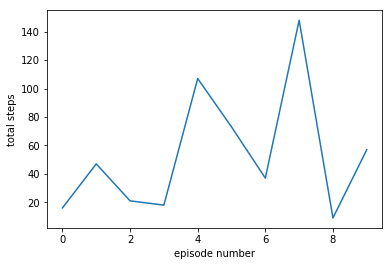

In [5]:
plt.xlabel('episode number')
plt.ylabel('total steps')
plt.plot(results)